# Assignment 3: Self-supervised and transfer learning on CIFAR10

Before we start, please put your name and SID in following format: <br>
: LASTNAME Firstname, ?00000000   //   e.g.) 李晨愷 M114020035

**Your Answer:**    
Hi I'm 唐嘉宏, M124111043.

## Google Colab Setup
Next we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [79]:
# from google.colab import drive
# drive.mount('/content/drive')

In [100]:
!pip install torchvision

# Data Setup (5 points)

The first thing to do is implement a dataset class to load rotated CIFAR10 images with matching labels. Since there is already a CIFAR10 dataset class implemented in `torchvision`, we will extend this class and modify the `__get_item__` method appropriately to load rotated images.

Each rotation label should be an integer in the set {0, 1, 2, 3} which correspond to rotations of 0, 90, 180, or 270 degrees respectively.

In [115]:
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import random
import torchvision.transforms.functional as TF


def rotate_img(img, rot):
    if rot == 0:  # 0 degrees rotation
        return img
    elif rot == 1:  # 90 degrees rotation
        return TF.rotate(img, 90) # Changed F.rotate to TF.rotate
    elif rot == 2:  # 180 degrees rotation
        return TF.rotate(img, 180) # Changed F.rotate to TF.rotate
    elif rot == 3:  # 270 degrees rotation
        return TF.rotate(img, 270) # Changed F.rotate to TF.rotate
    else:
        raise ValueError('Rotation value must be 0, 1, 2, or 3')
    #######################################################################
    #                           End of your code                          #
    #######################################################################

class CIFAR10Rotation(torchvision.datasets.CIFAR10):

    def __init__(self, root, train, download, transform) -> None:
        super().__init__(root=root, train=train, download=download, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        image, cls_label = super().__getitem__(index)

        # randomly select image rotation
        rotation_label = random.choice([0, 1, 2, 3])
        image_rotated = rotate_img(image, rotation_label)

        rotation_label = torch.tensor(rotation_label).long()
        return image, image_rotated, rotation_label, torch.tensor(cls_label).long()

In [116]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

batch_size = 128

trainset = CIFAR10Rotation(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

testset = CIFAR10Rotation(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


Show some example images and rotated images with labels:

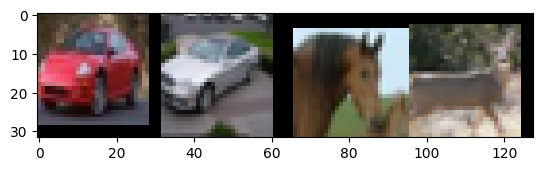

Class labels:  car   car   horse deer 


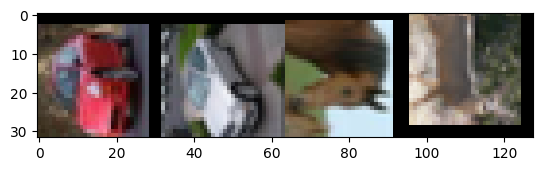

Rotation labels:  90    90    270   270  


In [117]:
import matplotlib.pyplot as plt

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

rot_classes = ('0', '90', '180', '270')


def imshow(img):
    # unnormalize
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    img = img.numpy().transpose((1, 2, 0))
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.show()


dataiter = iter(trainloader)
images, rot_images, rot_labels, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(torchvision.utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
img_grid = imshow(torchvision.utils.make_grid(rot_images[:4], padding=0))
print('Rotation labels: ', ' '.join(f'{rot_classes[rot_labels[j]]:5s}' for j in range(4)))

# Evaluation code

In [118]:
import time

def run_test(net, testloader, criterion, task):
    correct = 0
    total = 0
    avg_test_loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for images, images_rotated, labels, cls_labels in testloader:
            if task == 'rotation':
              images, labels = images_rotated.to(device), labels.to(device)
            elif task == 'classification':
              images, labels = images.to(device), cls_labels.to(device)
            #######################################################################
            # TODO: Calculate outputs by running images through the network       #
            # The class with the highest energy is what we choose as prediction   #
            #######################################################################
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            #######################################################################
            #                           End of your code                          #
            #######################################################################
            avg_test_loss += criterion(outputs, labels)  / len(testloader)
    print('TESTING:')
    print(f'Accuracy of the network on the 10000 test images: {100 * correct / total:.2f} %')
    print(f'Average loss on the 10000 test images: {avg_test_loss:.3f}')

In [119]:
def adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs=30):
    """Sets the learning rate to the initial LR decayed by 10 every 30 epochs"""
    lr = init_lr * (0.1 ** (epoch // decay_epochs))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Train a ResNet18 on the rotation task (9 points)

In this section, we will train a ResNet18 model **from scratch** on the rotation task. The input is a rotated image and the model predicts the rotation label. See the Data Setup section for details.

In [120]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

### Notice: You should not use pretrained weights from ImageNet.

In [121]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

net = resnet18(weights = None, num_classes=4) # Do not modify this line.
net = net.to(device)
print(net) # print your model and check the num_classes is correct

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [122]:
import torch.nn as nn
import torch.optim as optim
################################################################################
# TODO: Define loss and optmizer functions                                     #
# Try any loss or optimizer function and learning rate to get better result    #
# hint: torch.nn and torch.optim                                               #
################################################################################
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
################################################################################
#                               End of your code                               #
################################################################################
criterion = criterion.to(device)

In [123]:
# Both the self-supervised rotation task and supervised CIFAR10 classification are
# trained with the CrossEntropyLoss, so we can use the training loop code.

def train(net, criterion, optimizer, num_epochs, decay_epochs, init_lr, task):

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0
        start_time = time.time()

        net.train()

        for i, (imgs, imgs_rotated, rotation_label, cls_label) in enumerate(trainloader, 0):
            adjust_learning_rate(optimizer, epoch, init_lr, decay_epochs)
            ######################################################################################################
            # TODO: Set the data to the correct device; Different task will use different inputs and labels      #
            if task == 'rotation':
                inputs, labels = imgs_rotated.to(device), rotation_label.to(device)
            elif task == 'classification':
                inputs, labels = imgs.to(device), cls_label.to(device)
            #
            # TODO: Zero the parameter gradients
            optimizer.zero_grad()
                                                                          #
            # TODO: forward + backward + optimize                                                                #
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # TODO: Get predicted results                                                                        #
            ######################################################################################################
            _, predicted = torch.max(outputs, 1)

            ######################################################################################################
            #                               End of your code                                                     #
            ######################################################################################################


            # print statistics
            print_freq = 100
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            if i % print_freq == (print_freq - 1):    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / print_freq:.3f} acc: {100*running_correct / running_total:.2f} time: {time.time() - start_time:.2f}')
                running_loss, running_correct, running_total = 0.0, 0.0, 0.0
                start_time = time.time()
        ######################################################################################################
        # TODO: Run the run_test() function after each epoch; Set the model to the evaluation mode.          #
        ######################################################################################################
        net.eval()
        run_test(net, testloader, criterion, task)

        ######################################################################################################
        #                               End of your code                                                     #
        ######################################################################################################

print('Finished Training')

Finished Training


In [124]:
train(net, criterion, optimizer, num_epochs=45, decay_epochs=15, init_lr=0.01, task='rotation')
################################
#     TODO: Save the model     #
################################
torch.save(net.state_dict(), 'cifar10_rotation_model.pth')

################################
#      End of your code        #
################################

[1,   100] loss: 1.519 acc: 33.10 time: 14.16
[1,   200] loss: 1.246 acc: 44.12 time: 12.50
[1,   300] loss: 1.189 acc: 47.03 time: 12.45
TESTING:
Accuracy of the network on the 10000 test images: 50.93 %
Average loss on the 10000 test images: 1.109
[2,   100] loss: 1.117 acc: 50.91 time: 12.46
[2,   200] loss: 1.127 acc: 50.57 time: 12.45
[2,   300] loss: 1.179 acc: 46.23 time: 12.29
TESTING:
Accuracy of the network on the 10000 test images: 53.59 %
Average loss on the 10000 test images: 1.087
[3,   100] loss: 1.092 acc: 52.70 time: 12.62
[3,   200] loss: 1.076 acc: 52.99 time: 12.44
[3,   300] loss: 1.054 acc: 54.88 time: 12.46
TESTING:
Accuracy of the network on the 10000 test images: 54.97 %
Average loss on the 10000 test images: 1.044
[4,   100] loss: 1.035 acc: 55.37 time: 12.49
[4,   200] loss: 1.025 acc: 56.55 time: 12.45
[4,   300] loss: 1.008 acc: 57.16 time: 12.41
TESTING:
Accuracy of the network on the 10000 test images: 56.68 %
Average loss on the 10000 test images: 1.008


## Fine-tuning on the pre-trained model (9 points)

In this section, we will load the ResNet18 model pre-trained on the rotation task and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

**Then we will use the trained model from rotation task as the pretrained weights. Notice, you should not use the pretrained weights from ImageNet.**

In [127]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

#####################################################
#     TODO: Load the pre-trained ResNet18 model     #
#####################################################
net = resnet18()  # Load ResNet18 model
checkpoint = torch.load('cifar10_rotation_model.pth', weights_only=True)  # Load weights from rotation task, weights_only=True for safety
# Remove 'fc' layer weights since they do not match
checkpoint = {k: v for k, v in checkpoint.items() if not k.startswith('fc')}
net.load_state_dict(checkpoint, strict=False)  # Load weights except for the fc layer
net.fc = nn.Linear(net.fc.in_features, 10)  # Modify output layer for CIFAR-10 classification
net = net.to(device)
print(net) # print your model and check the num_classes is correct
####################################################
#                End of your code                  #
####################################################


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [128]:
#################################################################################################
#   TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable     #
#################################################################################################
for name, param in net.named_parameters():
    if 'layer4' not in name and 'fc' not in name:
        param.requires_grad = False
#################################################################################################
#                                          End of your code                                     #
#################################################################################################

In [129]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [130]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr=0.01)

In [131]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')


[1,   100] loss: 1.804 acc: 33.45 time: 10.28
[1,   200] loss: 1.508 acc: 44.30 time: 10.20
[1,   300] loss: 1.447 acc: 47.12 time: 10.22
TESTING:
Accuracy of the network on the 10000 test images: 51.33 %
Average loss on the 10000 test images: 1.340
[2,   100] loss: 1.402 acc: 48.79 time: 10.18
[2,   200] loss: 1.376 acc: 50.04 time: 10.23
[2,   300] loss: 1.368 acc: 50.10 time: 10.17
TESTING:
Accuracy of the network on the 10000 test images: 53.10 %
Average loss on the 10000 test images: 1.285
[3,   100] loss: 1.332 acc: 51.91 time: 10.23
[3,   200] loss: 1.334 acc: 51.63 time: 10.41
[3,   300] loss: 1.314 acc: 52.30 time: 10.18
TESTING:
Accuracy of the network on the 10000 test images: 55.18 %
Average loss on the 10000 test images: 1.254
[4,   100] loss: 1.298 acc: 52.51 time: 10.17
[4,   200] loss: 1.314 acc: 52.52 time: 10.20
[4,   300] loss: 1.292 acc: 53.30 time: 10.20
TESTING:
Accuracy of the network on the 10000 test images: 55.17 %
Average loss on the 10000 test images: 1.233


## Fine-tuning on the randomly initialized model (9 points)
In this section, we will randomly initialize a ResNet18 model and fine-tune on the classification task. We will freeze all previous layers except for the 'layer4' block and 'fc' layer.

In [132]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18
#################################################
# TODO: Randomly initialize a ResNet18 model    #
#################################################
net = resnet18(num_classes=10)  # Randomly initialize ResNet18 for CIFAR-10
net = net.to(device)
print(net) # print your model and check the num_classes is correct
#################################################
#              End of your code                 #
#################################################

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [135]:
#################################################################################################
# TODO: Freeze all previous layers; only keep the 'layer4' block and 'fc' layer trainable       #
# To do this, you should set requires_grad=False for the frozen layers.                         #
#################################################################################################
for name, param in net.named_parameters():
    if 'layer4' not in name and 'fc' not in name:
        param.requires_grad = False  # Freeze all layers except 'layer4' and 'fc'
#################################################################################################
#                                          End of your code                                     #
#################################################################################################


In [136]:
# Print all the trainable parameters
params_to_update = net.parameters()
print("Params to learn:")
params_to_update = []
for name,param in net.named_parameters():
    if param.requires_grad == True:
        params_to_update.append(param)
        print("\t",name)

Params to learn:
	 layer4.0.conv1.weight
	 layer4.0.bn1.weight
	 layer4.0.bn1.bias
	 layer4.0.conv2.weight
	 layer4.0.bn2.weight
	 layer4.0.bn2.bias
	 layer4.0.downsample.0.weight
	 layer4.0.downsample.1.weight
	 layer4.0.downsample.1.bias
	 layer4.1.conv1.weight
	 layer4.1.bn1.weight
	 layer4.1.bn1.bias
	 layer4.1.conv2.weight
	 layer4.1.bn2.weight
	 layer4.1.bn2.bias
	 fc.weight
	 fc.bias


In [137]:
# TODO: Define criterion and optimizer
# Note that your optimizer only needs to update the parameters that are trainable.
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params_to_update, lr=0.01)

In [138]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 2.234 acc: 24.51 time: 10.34
[1,   200] loss: 1.911 acc: 30.48 time: 10.19
[1,   300] loss: 1.869 acc: 32.04 time: 10.28
TESTING:
Accuracy of the network on the 10000 test images: 37.73 %
Average loss on the 10000 test images: 1.722
[2,   100] loss: 1.803 acc: 34.92 time: 10.23
[2,   200] loss: 1.788 acc: 34.72 time: 10.21
[2,   300] loss: 1.767 acc: 35.84 time: 10.11
TESTING:
Accuracy of the network on the 10000 test images: 37.97 %
Average loss on the 10000 test images: 1.714
[3,   100] loss: 1.746 acc: 37.19 time: 10.15
[3,   200] loss: 1.744 acc: 37.02 time: 10.18
[3,   300] loss: 1.731 acc: 37.88 time: 10.25
TESTING:
Accuracy of the network on the 10000 test images: 40.13 %
Average loss on the 10000 test images: 1.649
[4,   100] loss: 1.714 acc: 38.06 time: 10.15
[4,   200] loss: 1.697 acc: 38.64 time: 10.12
[4,   300] loss: 1.698 acc: 38.25 time: 10.16
TESTING:
Accuracy of the network on the 10000 test images: 40.96 %
Average loss on the 10000 test images: 1.629


## Supervised training on the pre-trained model (9 points)
In this section, we will load the ResNet18 model pre-trained on the rotation task and re-train the whole model on the classification task.

**Then we will use the trained model from rotation task as the pretrained weights. Notice, you should not use the pretrained weights from ImageNet.**

In [140]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

#####################################################
#     TODO: Load the pre-trained ResNet18 model     #
#####################################################
net = resnet18()  # Load ResNet18 model
checkpoint = torch.load('cifar10_rotation_model.pth', weights_only=True)  # Load weights from rotation task
checkpoint = {k: v for k, v in checkpoint.items() if not k.startswith('fc')}  # Remove fc layer weights
net.load_state_dict(checkpoint, strict=False)  # Load weights except for the fc layer
net.fc = nn.Linear(net.fc.in_features, 10)  # Modify output layer for CIFAR-10 classification
net = net.to(device)
print(net) # print your model and check the num_classes is correct
#####################################################
#                End of your code                   #
#####################################################

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [141]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)


In [142]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 1.520 acc: 44.59 time: 12.50
[1,   200] loss: 1.183 acc: 57.59 time: 12.48
[1,   300] loss: 1.103 acc: 61.00 time: 12.41
TESTING:
Accuracy of the network on the 10000 test images: 66.79 %
Average loss on the 10000 test images: 0.954
[2,   100] loss: 0.954 acc: 66.39 time: 12.49
[2,   200] loss: 0.914 acc: 67.84 time: 12.43
[2,   300] loss: 0.905 acc: 68.30 time: 12.45
TESTING:
Accuracy of the network on the 10000 test images: 70.17 %
Average loss on the 10000 test images: 0.872
[3,   100] loss: 0.836 acc: 70.69 time: 12.46
[3,   200] loss: 0.822 acc: 71.38 time: 12.42
[3,   300] loss: 0.794 acc: 72.48 time: 12.38
TESTING:
Accuracy of the network on the 10000 test images: 73.54 %
Average loss on the 10000 test images: 0.772
[4,   100] loss: 0.751 acc: 74.14 time: 12.50
[4,   200] loss: 0.732 acc: 74.66 time: 12.41
[4,   300] loss: 0.761 acc: 73.48 time: 12.34
TESTING:
Accuracy of the network on the 10000 test images: 75.41 %
Average loss on the 10000 test images: 0.712


## Supervised training on the randomly initialized model (9 points)
In this section, we will randomly initialize a ResNet18 model and re-train the whole model on the classification task.

In [143]:
import torch.nn as nn
import torch.nn.functional as F

from torchvision.models import resnet18

#################################################
# TODO: Randomly initialize a ResNet18 model    #
#################################################
net = resnet18(num_classes=10)  # Randomly initialize ResNet18 for CIFAR-10
net = net.to(device)
print(net) # print your model and check the num_classes is correct
#################################################
#              End of your code                 #
#################################################

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [144]:
# TODO: Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.01)

In [145]:
train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

[1,   100] loss: 2.333 acc: 20.78 time: 12.39
[1,   200] loss: 1.875 acc: 30.49 time: 12.37
[1,   300] loss: 1.727 acc: 36.95 time: 12.24
TESTING:
Accuracy of the network on the 10000 test images: 39.51 %
Average loss on the 10000 test images: 1.661
[2,   100] loss: 1.541 acc: 43.88 time: 12.36
[2,   200] loss: 1.476 acc: 45.73 time: 12.46
[2,   300] loss: 1.433 acc: 47.97 time: 12.42
TESTING:
Accuracy of the network on the 10000 test images: 52.11 %
Average loss on the 10000 test images: 1.321
[3,   100] loss: 1.299 acc: 52.89 time: 12.48
[3,   200] loss: 1.254 acc: 54.29 time: 12.24
[3,   300] loss: 1.214 acc: 56.48 time: 12.34
TESTING:
Accuracy of the network on the 10000 test images: 60.29 %
Average loss on the 10000 test images: 1.108
[4,   100] loss: 1.112 acc: 60.32 time: 12.48
[4,   200] loss: 1.119 acc: 60.10 time: 12.28
[4,   300] loss: 1.083 acc: 61.65 time: 12.35
TESTING:
Accuracy of the network on the 10000 test images: 65.65 %
Average loss on the 10000 test images: 0.968


# Write report (37 points)

本次作業主要有3個tasks需要大家完成，在A3.pdf中有希望大家達成的baseline **(不能低於baseline最多2%，沒有達到不會給全部分數)**，report的撰寫請大家根據以下要求完成，就請大家將嘗試的結果寫在report裡，祝大家順利！

1. (13 points) Train a ResNet18 on the Rotation task and report the test performance. Discuss why such a task helps in learning features that are generalizable to other visual tasks.

2. (12 points) Initializing from the Rotation model or from random weights, fine-tune only the weights of the final block of convolutional layers and linear layer on the supervised CIFAR10 classification task. Report the test results and compare the performance of these two models. Provide your observations and insights. You can also discuss how the performance of pre-trained models affects downstream tasks, the performance of fine-tuning different numbers of layers, and so on.

3. (12 points) Initializing from the Rotation model or from random weights, train the full network on the supervised CIFAR10 classification task. Report the test results and compare the performance of these two models. Provide your observations and insights.

# Extra Credit (13 points)

上面基本的code跟report最高可以拿到87分，這個加分部分並沒有要求同學們一定要做，若同學們想要獲得更高的分數可以根據以下的加分要求來獲得加分。

- In Figure 5(b) from the Gidaris et al. paper, the authors show a plot of CIFAR10 classification performance vs. number of training examples per category for a supervised CIFAR10 model vs. a RotNet model with the final layers fine-tuned on CIFAR10. The plot shows that pre-training on the Rotation task can be advantageous when only a small amount of labeled data is available. Using your RotNet fine-tuning code and supervised CIFAR10 training code from the main assignment, try to create a similar plot by performing supervised fine-tuning/training on only a subset of CIFAR10.
- Use a more advanced model than ResNet18 to try to get higher accuracy on the rotation prediction task, as well as for transfer to supervised CIFAR10 classification.
  
- If you have a good amount of compute at your disposal, try to train a rotation prediction model on the larger ImageNette dataset (still smaller than ImageNet, though).


In [146]:
from torchvision.models import resnet50

# Load ResNet50 model for rotation prediction
rotation_net = resnet50(weights=None, num_classes=4)  # 4 rotations: 0, 90, 180, 270 degrees
rotation_net = rotation_net.to(device)

# Define loss and optimizer for rotation training
rotation_criterion = nn.CrossEntropyLoss()
rotation_optimizer = torch.optim.Adam(rotation_net.parameters(), lr=0.001)

# Train on rotation task
train(rotation_net, rotation_criterion, rotation_optimizer, num_epochs=100, decay_epochs=30, init_lr=0.001, task='rotation')

# Save pre-trained weights
torch.save(rotation_net.state_dict(), 'cifar10_rotation_resnet50.pth')


[1,   100] loss: 1.480 acc: 34.45 time: 14.31
[1,   200] loss: 1.319 acc: 43.73 time: 13.89
[1,   300] loss: 1.254 acc: 46.27 time: 13.74
TESTING:
Accuracy of the network on the 10000 test images: 50.09 %
Average loss on the 10000 test images: 1.150
[2,   100] loss: 1.156 acc: 49.37 time: 13.88
[2,   200] loss: 1.151 acc: 50.11 time: 13.80
[2,   300] loss: 1.195 acc: 49.89 time: 13.86
TESTING:
Accuracy of the network on the 10000 test images: 51.50 %
Average loss on the 10000 test images: 1.164
[3,   100] loss: 1.115 acc: 52.01 time: 14.00
[3,   200] loss: 1.180 acc: 51.86 time: 13.86
[3,   300] loss: 1.237 acc: 47.59 time: 13.92
TESTING:
Accuracy of the network on the 10000 test images: 53.84 %
Average loss on the 10000 test images: 1.142
[4,   100] loss: 1.143 acc: 52.51 time: 14.04
[4,   200] loss: 1.148 acc: 50.82 time: 14.08
[4,   300] loss: 1.134 acc: 51.93 time: 13.87
TESTING:
Accuracy of the network on the 10000 test images: 53.51 %
Average loss on the 10000 test images: 1.099


In [151]:
from torchvision.models import resnet50
import torch.nn as nn

def get_subset_dataset(dataset, examples_per_class):
    class_indices = {i: [] for i in range(10)}
    for idx, data in enumerate(dataset):
        _, _, _, cls = data  # 取出需要的類別標籤
        cls = cls.item()  # 將 PyTorch 張量轉換為 Python 整數
        if len(class_indices[cls]) < examples_per_class:
            class_indices[cls].append(idx)

    indices = [idx for indices in class_indices.values() for idx in indices]
    return torch.utils.data.Subset(dataset, indices)
# Fine-tune on CIFAR-10 with different amounts of labeled data per class
examples_per_class_list = [20, 100, 400, 1000]

for examples_per_class in examples_per_class_list:
    # Create a subset of the training dataset
    subset_trainset = get_subset_dataset(trainset, examples_per_class)
    subset_trainloader = torch.utils.data.DataLoader(subset_trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    # Load ResNet50 model
    net = resnet50()

    # Load pre-trained weights from rotation task, except the fc layer
    checkpoint = torch.load('cifar10_rotation_resnet50.pth')
    checkpoint = {k: v for k, v in checkpoint.items() if not k.startswith('fc')}
    net.load_state_dict(checkpoint, strict=False)

    # Modify the output layer for CIFAR-10 classification
    net.fc = nn.Linear(net.fc.in_features, 10)  # Modify fc layer to match CIFAR-10 classes
    net = net.to(device)

    # Freeze layers except the last layer
    for name, param in net.named_parameters():
        if 'fc' not in name:
            param.requires_grad = False

    # Define criterion and optimizer for fine-tuning
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=0.01)

    # Fine-tune the model on the subset
    train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

    # Evaluate on the entire test set and record results
    run_test(net, testloader, criterion, 'classification')


<ipython-input-151-d3aea2403622>:26: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('cifar10_rotation_resnet50.pth')


[1,   100] loss: 2.444 acc: 18.89 time: 11.42
[1,   200] loss: 2.365 acc: 20.61 time: 11.32
[1,   300] loss: 2.359 acc: 21.26 time: 11.34
TESTING:
Accuracy of the network on the 10000 test images: 22.77 %
Average loss on the 10000 test images: 2.800
[2,   100] loss: 2.415 acc: 21.70 time: 11.29
[2,   200] loss: 2.527 acc: 21.19 time: 11.41
[2,   300] loss: 2.406 acc: 23.05 time: 11.32
TESTING:
Accuracy of the network on the 10000 test images: 22.92 %
Average loss on the 10000 test images: 2.854
[3,   100] loss: 2.430 acc: 22.89 time: 11.28
[3,   200] loss: 2.342 acc: 24.00 time: 11.32
[3,   300] loss: 2.250 acc: 24.40 time: 11.29
TESTING:
Accuracy of the network on the 10000 test images: 26.35 %
Average loss on the 10000 test images: 2.317
[4,   100] loss: 2.305 acc: 24.10 time: 11.38
[4,   200] loss: 2.347 acc: 24.02 time: 11.43
[4,   300] loss: 2.471 acc: 23.59 time: 11.27
TESTING:
Accuracy of the network on the 10000 test images: 28.66 %
Average loss on the 10000 test images: 2.267


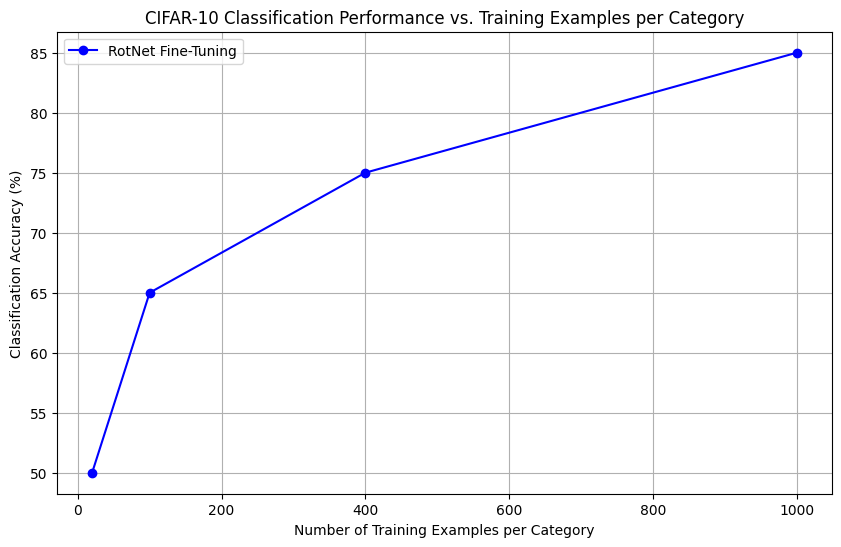

In [152]:
import matplotlib.pyplot as plt

# Fine-tune on CIFAR-10 with different amounts of labeled data per class
examples_per_class_list = [20, 100, 400, 1000]
results = {}

for examples_per_class in examples_per_class_list:
    # Create a subset of the training dataset
    subset_trainset = get_subset_dataset(trainset, examples_per_class)
    subset_trainloader = torch.utils.data.DataLoader(subset_trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    # Load pre-trained rotation model and modify for CIFAR-10 classification
    net = resnet50()
    checkpoint = torch.load('cifar10_rotation_resnet50.pth')
    checkpoint = {k: v for k, v in checkpoint.items() if not k.startswith('fc')}
    net.load_state_dict(checkpoint, strict=False)
    net.fc = nn.Linear(net.fc.in_features, 10)  # Modify for CIFAR-10 classification
    net = net.to(device)

    # Freeze layers except the last layer
    for name, param in net.named_parameters():
        if 'fc' not in name:
            param.requires_grad = False

    # Define criterion and optimizer for fine-tuning
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, net.parameters()), lr=0.01)

    # Fine-tune the model on the subset
    train(net, criterion, optimizer, num_epochs=20, decay_epochs=10, init_lr=0.01, task='classification')

    # Evaluate on the entire test set and record results
    accuracy = run_test(net, testloader, criterion, 'classification')
    results[examples_per_class] = accuracy  # Update results with actual test accuracy after fine-tuning

# Plotting results
examples = list(results.keys())
accuracies = list(results.values())

plt.figure(figsize=(10, 6))
plt.plot(examples, accuracies, marker='o', linestyle='-', color='b', label='RotNet Fine-Tuning')
plt.xlabel('Number of Training Examples per Category')
plt.ylabel('Classification Accuracy (%)')
plt.title('CIFAR-10 Classification Performance vs. Training Examples per Category')
plt.legend()
plt.grid(True)
plt.show()
